# Analysis for recycle scenarios

This notebook provides analysis for all of the recycle scenarios that are included in 
Amanda Bachmann's disseration. Analysis of each scenario includes the uranium resoucre, 
SWU capacity and the amount of waste disposed. 

Scenarios are numbered as follows:
* Scenario 14: Limited reycle of all fuel, no energy growth
* Scenario 15: Limited recycle of non-TRISO fuel, no energy growth
* Scenario 16: Continuous recycle, no energy growth
* Scenario 17: Limited recycle of all fuel, 1% eergy growth
* Scenario 18: Limited recycle of non-TRISO fuel, 1% energy growth
* Scenario 19: Continuos recycle, 1% energy growth

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

sys.path.append("../../../scripts")
import dataframe_analysis as dfa
import transition_metrics as tm

In [2]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.1975, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002,
         'SFR':0.1979}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'LWREnrichment', 'MMREnrichment', 'Xe100Enrichment',
                 'VOYGREnrichment','United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe100_UOX_Cooling',
                 'MMR_UOX_Cooling', 'VOYGR_UOX_Cooling',
                 'Xe100_MOX_Mixer', 'VOYGR_MOX_Mixer', 'MOXCoolingPool',
                 'SeparationsFacility', 'SeparationsInstitution', 'Sink_LWR_UOX', 'SFR']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR', 'SFR']

colors = {'s14':'tab:orange', 's15':'tab:purple','s16':'tab:brown',
                   's17':'tab:orange', 's18':'tab:purple','s19':'tab:brown'}
lines = {'s14':(0,(3,5,1)), 's15':(0,(5,3)),'s16':'-.',
                's17':(0,(3,5,1)), 's18':(0,(5,3)),'s19':'-.',}
labels = {'s14':'Scenario 14', 's15':'Scenario 15', 's16':'Scenario 16', 's17':'Scenario 17',
         's18':'Scenario 18', 's19':'Scenario 19'}
legend_order = [1, 5, 4, 0, 2, 3]

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.881481, 'Xe-100':0.895285, 'VOYGR':0.881481,
                    'SFR':0.9}
hm_fractions = {'VOYGR':0.88151, 'Xe-100':0.89618, 'SFR':0.9}
natu_fractions = {'Xe-100':0.85105, 'VOYGR':0.97943, 'SFR':0.76588} # fraction of heavy metal that is Nat U

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel',
                  'SFR':'spent_haleu'}
uox_commodity = {'LWR':'fresh_uox', 'MMR':'fresh_MMR_uox',
                   'Xe-100':'fresh_xe100_uox', 'VOYGR':'fresh_smr_uox', 
                   'SFR':'fresh_haleu'}
mox_commodity = {'Xe-100':'fresh_xe100_mox', 'VOYGR':'fresh_smr_mox',
                'SFR':'fresh_reprocessed'}

#Time period
time = np.linspace(2025, 2089, 65)

out_files = {'s14':'../outputs/scenario14.sqlite', 's15':'../outputs/scenario15.sqlite',
             's16':'../outputs/scenario16.sqlite', 's17':'../outputs/scenario17.sqlite',
             's18':'../outputs/scenario18.sqlite', 's19':'../outputs/scenario19.sqlite'}


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## No growth demand

### Reactor numbers -- match up with once through scenarios

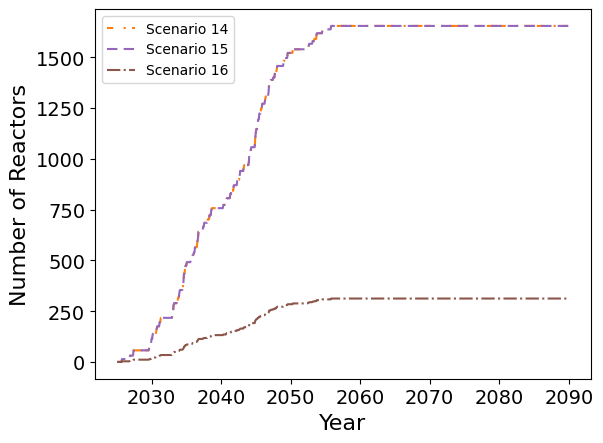

In [3]:
reactors_nogrowth = {'s14':'','s15':'','s16':''}
plt.figure(0)
for scenario in reactors_nogrowth:
    reactors_nogrowth[scenario] = tm.get_prototype_totals(out_files[scenario], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[scenario]['Year'][721:], reactors_nogrowth[scenario]['advrx_total'][721:], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_recycle_reactors.pdf', bbox_inches='tight')

In [5]:
for scenario in reactors_nogrowth:
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in {scenario}:', reactors_nogrowth[scenario][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in {scenario}:', reactors_nogrowth[scenario][adv_rx +'_enter'].max())
        prototype_sum = reactors_nogrowth[scenario][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in {scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in {scenario}:', reactors_nogrowth[scenario]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in {scenario}:', reactors_nogrowth[scenario]['advrx_enter'].max())
    advrx_sum = reactors_nogrowth[scenario]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in {scenario}:', advrx_sum.iloc[-1])  

Max MMR in s14: 542.0
Max MMR added in one step in s14: 16.0
Total number of MMR deployed in s14: 1633.0
Max Xe-100 in s14: 1105.0
Max Xe-100 added in one step in s14: 46.0
Total number of Xe-100 deployed in s14: 1155.0
Max VOYGR in s14: 7.0
Max VOYGR added in one step in s14: 1.0
Total number of VOYGR deployed in s14: 7.0
Max SFR in s14: 0.0
Max SFR added in one step in s14: 0.0
Total number of SFR deployed in s14: 0.0
Max Adv Rx in s14: 1654.0
Max Adv Rx added in one step in s14: 52.0
Total number of reactors deployed in s14: 2795.0
Max MMR in s15: 542.0
Max MMR added in one step in s15: 16.0
Total number of MMR deployed in s15: 1633.0
Max Xe-100 in s15: 1105.0
Max Xe-100 added in one step in s15: 46.0
Total number of Xe-100 deployed in s15: 1155.0
Max VOYGR in s15: 7.0
Max VOYGR added in one step in s15: 1.0
Total number of VOYGR deployed in s15: 7.0
Max SFR in s15: 0.0
Max SFR added in one step in s15: 0.0
Total number of SFR deployed in s15: 0.0
Max Adv Rx in s15: 1654.0
Max Adv R

### Fuel Mass

In [3]:
transactions_nogrowth = {'s14':'', 's15':'', 's16':''}

for key in transactions_nogrowth:
    scenario = key[:3]
    transactions_nogrowth[scenario] = tm.add_receiver_prototype(out_files[scenario])

In [4]:
# Divide up fuel mass by prototype
uranium_to_reactors = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':'',
                       's15_MMR':'', 's15_Xe-100':'', 's15_VOYGR':'', 's15_LWR':'',
                       's16_SFR':'', 's16_LWR':''}
mox_to_reactors = {'s14_Xe-100':'', 's14_VOYGR':'', 
                   's15_Xe-100':'', 's15_VOYGR':'',
                   's16_SFR':''}

for key in uranium_to_reactors:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors[key] = dfa.commodity_to_LWR(transactions_nogrowth[scenario], 
                                                       'fresh_uox',adv_rxs)
    else:
        uranium_to_reactors[key] = dfa.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                       uox_commodity[reactor], reactor)
        uranium_to_reactors[key]['Quantity'] = uranium_to_reactors[key]['Quantity']*uranium_fractions[reactor]
    if reactor == 'Xe-100' or reactor == 'VOYGR' or reactor == 'SFR':
        mox_to_reactors[key] = dfa.commodity_to_prototype(transactions_nogrowth[scenario],
                                                 mox_commodity[reactor], reactor)
        mox_to_reactors[key]['Quantity'] = mox_to_reactors[key]['Quantity']*hm_fractions[reactor]

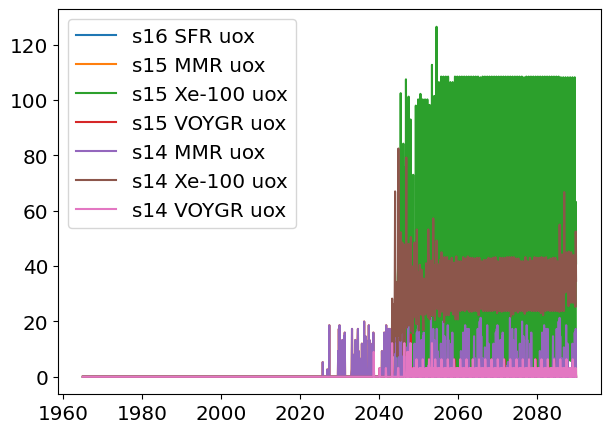

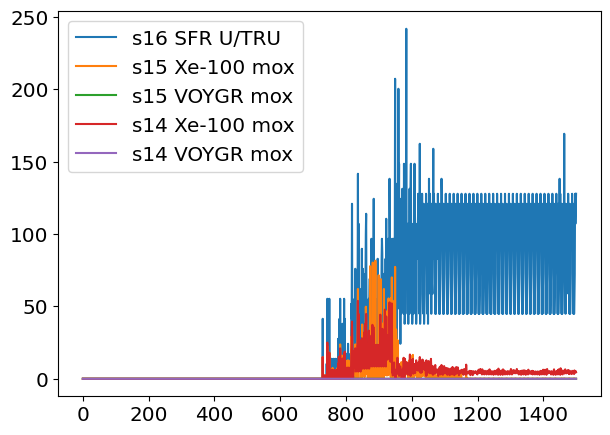

In [5]:
for scenario in ['s16','s15','s14']:
    plt.figure(0)
    if scenario == 's16':
        plt.plot(uranium_to_reactors[scenario + '_SFR']['Year'],
                 uranium_to_reactors[scenario + '_SFR']['Quantity']/1000, label = (scenario + ' SFR uox'))
    else:
        for reactor in ['MMR', 'Xe-100','VOYGR']:
            plt.plot(uranium_to_reactors[scenario + '_' + reactor]['Year'],
                     uranium_to_reactors[scenario + '_' + reactor]['Quantity']/1000, label = (scenario + ' ' + reactor+' uox'))
    plt.legend()

    plt.figure(1)
    if scenario == 's16':
        plt.plot(mox_to_reactors[scenario + '_SFR']['Quantity']/1000, label = (scenario + ' SFR U/TRU'))
    else:
        for reactor in ['Xe-100', 'VOYGR']:
            plt.plot(mox_to_reactors[scenario + '_' + reactor]['Quantity']/1000, label = (scenario + ' ' + reactor+' mox'))
    plt.legend()

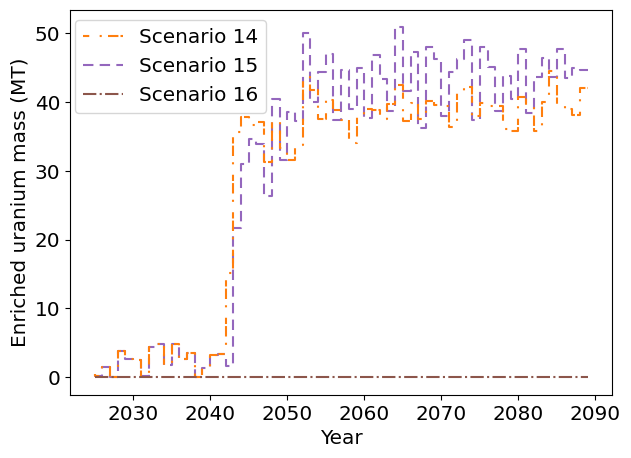

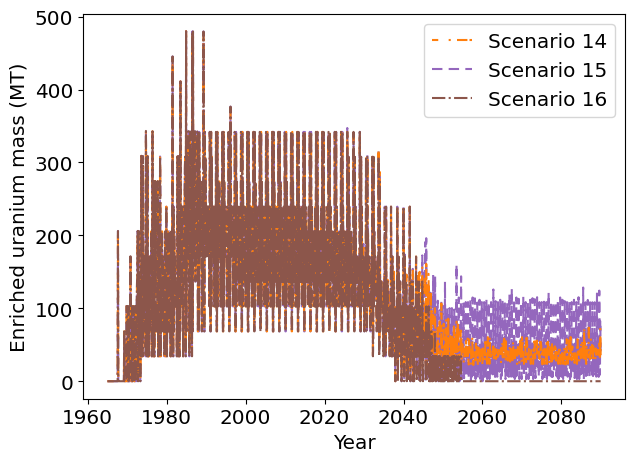

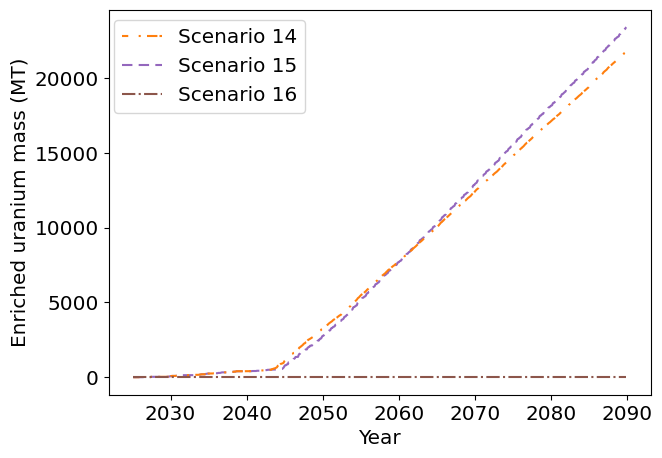

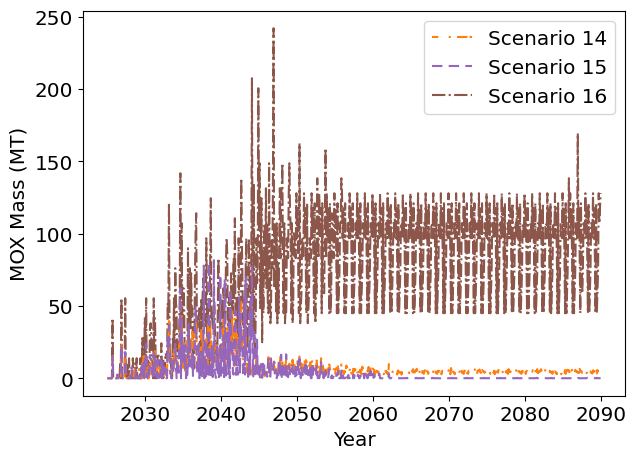

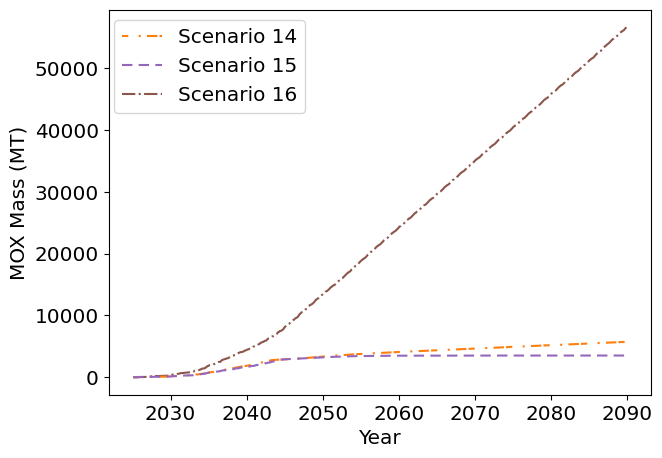

In [8]:
for key in ['s15','s14','s16']:
    if key == 's16':
        AR_uranium = uranium_to_reactors[key + '_SFR'].copy()
    else:
        AR_uranium = uranium_to_reactors[key + '_MMR'].copy()
        for reactor in ['Xe-100', 'VOYGR']:
            AR_uranium['Quantity'] += uranium_to_reactors[key + '_' + reactor]['Quantity']
    averages = []
    counter = 721
    for ii in range(0, 65):
        year_data = AR_uranium['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter +=12
        
    ax0=plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key], 
            color =colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    
    total_uranium = AR_uranium['Quantity'] + uranium_to_reactors[key + '_LWR']['Quantity']
    ax1=plt.figure(1)
    plt.plot(AR_uranium['Year'], total_uranium/1000, 
            label = labels[key], color = colors[key], linestyle=lines[key]) 
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    
    ax2=plt.figure(2)
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')

for key in ['s16','s14','s15']:
    if key == 's16':
        total_mox = mox_to_reactors[key+'_SFR']['Quantity']
    else:
        total_mox = mox_to_reactors[key+'_Xe-100']['Quantity'] + mox_to_reactors[key+'_VOYGR']['Quantity']
    ax3=plt.figure(3)
    plt.plot(AR_uranium['Year'][721:], total_mox[721:]/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('MOX Mass (MT)')

    ax4=plt.figure(4)
    plt.plot(AR_uranium['Year'][721:], total_mox[721:].cumsum()/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('MOX Mass (MT)')
    
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax0.savefig("figures/nogrowth_recycle_Uaverages.pdf", bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.90, 0.88))
ax1.savefig("figures/nogrowth_recycle_total_fuel.pdf", bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax2.savefig("figures/nogrowth_recycle_Ucumulative.pdf", bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in [1,2,0]],[legend_labels[idx] for idx in [1,2,0]], bbox_to_anchor=(0.90, 0.88))
ax3.savefig("figures/nogrowth_recycle_MOX.pdf", bbox_inches='tight')
handles, legend_labels = ax4.gca().get_legend_handles_labels()
ax4.legend([handles[idx] for idx in [1,2,0]],[legend_labels[idx] for idx in [1,2,0]], bbox_to_anchor=(0.42, 0.88))
ax4.savefig("figures/nogrowth_recycle_MOXcumulative.pdf", bbox_inches='tight')

In [9]:
#Reporting UOX masses
for scenario in transactions_nogrowth:
    if scenario == 's16':
        HALEU_mass = uranium_to_reactors[scenario+'_SFR']
        AR_mass = HALEU_mass
    else:
        HALEU_mass = uranium_to_reactors[scenario+'_MMR'] + uranium_to_reactors[scenario+'_Xe-100']
        AR_mass = HALEU_mass + uranium_to_reactors[scenario+'_VOYGR']
        print('Non-HALEU max in:',scenario, uranium_to_reactors[scenario+'_VOYGR'][721:]['Quantity'].max()/1000)
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:]['Quantity'].mean()/1000)
    print('Average mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].mean()/1000)
    print('Maximum mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].max()/1000)
    print('Cumulative mass in', scenario, 'after 2025:',AR_mass[721:]['Quantity'].cumsum()[1499]/1000)

Non-HALEU max in: s14 12.161793356999999
Average HALEU mass in s14 after 2025: 27.15806870581743
Average mass in s14 after 2025: 28.010174843718662
Maximum mass in s14 after 2025: 87.00540971088598
Cumulative mass in s14 after 2025: 21819.926203256844
Non-HALEU max in: s15 15.323859629820001
Average HALEU mass in s15 after 2025: 29.195582719412293
Average mass in s15 after 2025: 30.047688857313528
Maximum mass in s15 after 2025: 143.830287571658
Cumulative mass in s15 after 2025: 23407.14961984722
Average HALEU mass in s16 after 2025: 0.0
Average mass in s16 after 2025: 0.0
Maximum mass in s16 after 2025: 0.0
Cumulative mass in s16 after 2025: 0.0


In [10]:
#Reporting MOX/U-TRU masses
for scenario in transactions_nogrowth:
    if scenario == 's16':
        MOX_mass = mox_to_reactors[scenario+'_SFR']
    else:
        MOX_mass = mox_to_reactors[scenario+'_VOYGR'] + mox_to_reactors[scenario+'_Xe-100']
    print('Average MOX mass in', scenario,'after 2025:', MOX_mass[721:]['Quantity'].mean()/1000)
    print('Maximum MOX mass in', scenario, 'after 2025:', 
          MOX_mass[721:]['Quantity'].max()/1000)
    print('Cumulative MOX mass in', scenario, 'after 2025:',MOX_mass[721:]['Quantity'].cumsum()[1499]/1000)

Average MOX mass in s14 after 2025: 7.351443551094222
Maximum MOX mass in s14 after 2025: 53.811307336
Cumulative MOX mass in s14 after 2025: 5726.7745263024
Average MOX mass in s15 after 2025: 4.505775287817201
Maximum MOX mass in s15 after 2025: 81.59295903039998
Cumulative MOX mass in s15 after 2025: 3509.998949209603
Average MOX mass in s16 after 2025: 72.69578433889602
Maximum MOX mass in s16 after 2025: 241.92
Cumulative MOX mass in s16 after 2025: 56630.016


### Natural uranium masses

In [11]:
tails_nogrowth = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':'',
                       's15_MMR':'', 's15_Xe-100':'', 's15_VOYGR':'', 's15_LWR':'',
                       's16_SFR':'', 's16_LWR':''}
feed_nogrowth = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':'',
                       's15_MMR':'', 's15_Xe-100':'', 's15_VOYGR':'', 's15_LWR':'',
                       's16_SFR':'', 's16_LWR':''}
SWU_nogrowth = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':'',
                       's15_MMR':'', 's15_Xe-100':'', 's15_VOYGR':'', 's15_LWR':'',
                       's16_SFR':'', 's16_LWR':''}
nat_u_nogrowth = {'s14_Xe-100':'', 's14_VOYGR':'', 
                   's15_Xe-100':'', 's15_VOYGR':'',
                   's16_SFR':''}

for key in tails_nogrowth:
    reactor = key[4:]
    tails_nogrowth[key] = dfa.calculate_tails(uranium_to_reactors[key]['Quantity'],
                                    assays[reactor], assays['tails'], assays['feed'])
    feed_nogrowth[key] = dfa.calculate_feed(uranium_to_reactors[key]['Quantity'],
                                  tails_nogrowth[key])
    SWU_nogrowth[key] = dfa.calculate_SWU(uranium_to_reactors[key]['Quantity'], assays[reactor],
                                tails_nogrowth[key], assays['tails'], feed_nogrowth[key], assays['feed'])
    if reactor in ['Xe-100', 'VOYGR','SFR']:
        nat_u_nogrowth[key] = natu_fractions[reactor]*mox_to_reactors[key]['Quantity']

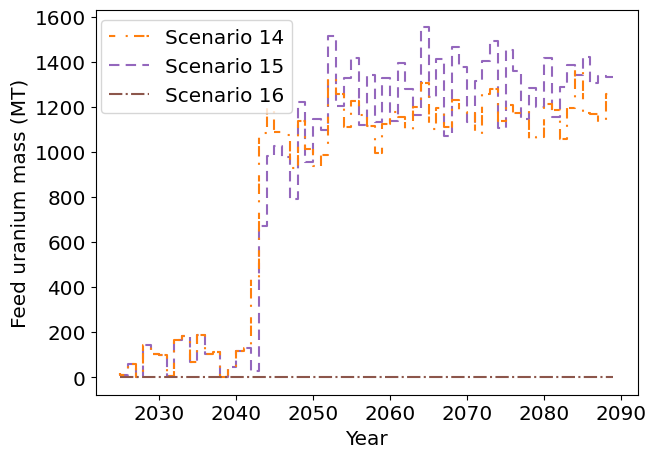

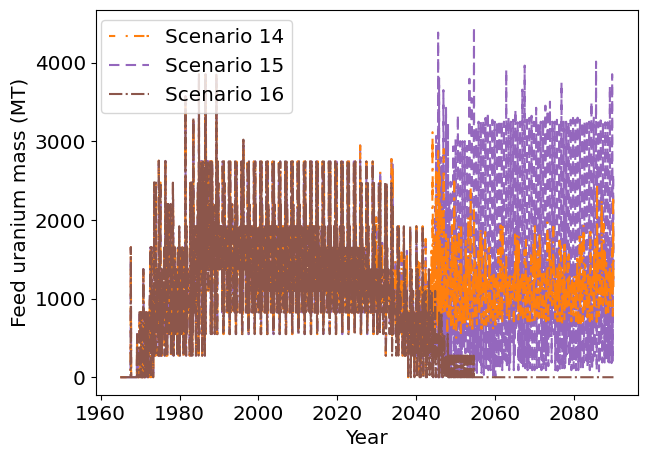

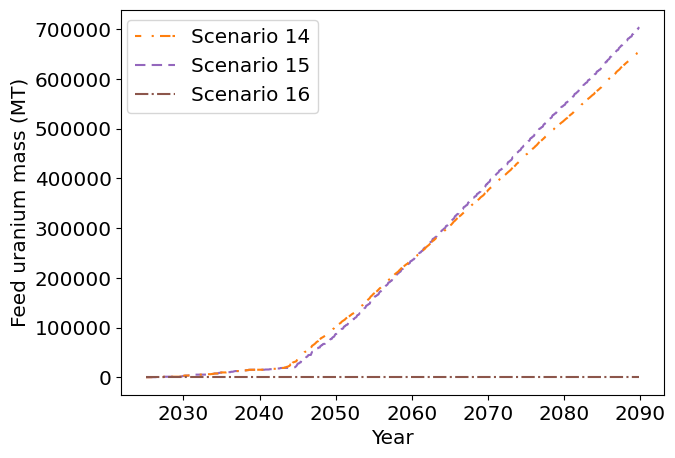

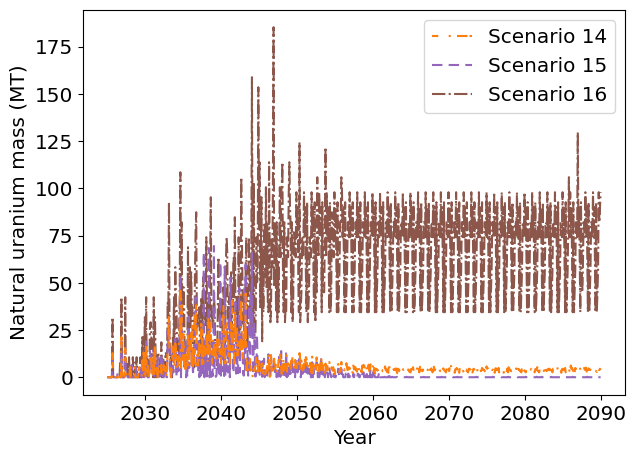

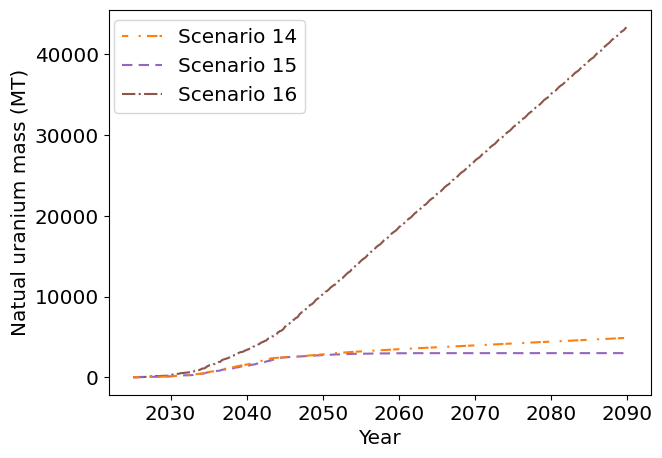

In [14]:
# Feed uranium
for scenario in ['s15','s14','s16']:
    if scenario == 's16':
        AR_feed = feed_nogrowth[scenario + '_SFR'].copy()
    else:
        AR_feed = feed_nogrowth[scenario + '_MMR'].copy()
        for reactor in ['Xe-100','VOYGR']:
            AR_feed += feed_nogrowth[scenario + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_feed[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12

    #yearly average for advanced reactors
    ax0 = plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')

    #monthly totals
    total_feed = AR_feed + feed_nogrowth[scenario + '_LWR']
    ax1=plt.figure(1)
    plt.plot(uranium_to_reactors[scenario + '_LWR']['Year'], total_feed/1000,
            label=labels[scenario], color = colors[scenario], linestyle=lines[scenario])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')

    #cumulative for only advanced reactors
    ax2=plt.figure(2)
    plt.plot(uranium_to_reactors[scenario + '_LWR']['Year'][721:], AR_feed[721:].cumsum()/1000,
            label=labels[scenario], color = colors[scenario], linestyle=lines[scenario])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')

for scenario in ['s16','s15','s14']:
    if scenario == 's16':
        nat_u = nat_u_nogrowth['s16_SFR']
    else:
        nat_u = nat_u_nogrowth[scenario + '_Xe-100'] + nat_u_nogrowth[scenario + '_VOYGR']    
    #nat U for MOX/U-TRU
    ax3=plt.figure(3)
    plt.plot(uranium_to_reactors[scenario + '_LWR']['Year'][721:], nat_u[721:]/1000,
            label=labels[scenario], color = colors[scenario], linestyle=lines[scenario])
    plt.xlabel('Year')
    plt.ylabel('Natural uranium mass (MT)')

    #cumulative nat U for MOX/U-TRU
    ax4=plt.figure(4)
    plt.plot(uranium_to_reactors[scenario + '_LWR']['Year'][721:], nat_u[721:].cumsum()/1000,
            label=labels[scenario], color = colors[scenario], linestyle=lines[scenario])
    plt.xlabel('Year')
    plt.ylabel('Natual uranium mass (MT)')

handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax0.savefig("figures/nogrowth_recycle_feed_average.pdf", bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax1.savefig("figures/nogrowth_recycle_feed.pdf", bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax2.savefig("figures/nogrowth_recycle_feed_cumulative.pdf", bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in [2,1,0]],[legend_labels[idx] for idx in [2,1,0]], bbox_to_anchor=(0.90, 0.88))
ax3.savefig("figures/nogrowth_recycle_natU.pdf", bbox_inches='tight')
handles, legend_labels = ax4.gca().get_legend_handles_labels()
ax4.legend([handles[idx] for idx in [2,1,0]],[legend_labels[idx] for idx in [2,1,0]], bbox_to_anchor=(0.42, 0.88))
ax4.savefig("figures/nogrowth_recycle_natU_cumulative.pdf", bbox_inches='tight')

In [15]:
#Reporting feed masses
for scenario in transactions_nogrowth:
    if scenario == 's16':
        HALEU_feed = feed_nogrowth[scenario+'_SFR']   
        AR_feed = HALEU_feed
    else:
        HALEU_feed = feed_nogrowth[scenario+'_MMR'] + feed_nogrowth[scenario+'_Xe-100']
        AR_feed = HALEU_feed + feed_nogrowth[scenario+'_VOYGR']
    print('Average feed for HALEU in',scenario, 'after 2025:', HALEU_feed[721:].mean()/1000)
    print('AR Average mass in', scenario, 'after 2025:', AR_feed[721:].mean()/1000)
    print('AR Maximum mass in', scenario, 'after 2025:', AR_feed[721:].max()/1000)
    print('AR Cumulative mass in', scenario, 'after 2025:', AR_feed[721:].cumsum()[1499]/1000)

Average feed for HALEU in s14 after 2025: 836.3660740864842
AR Average mass in s14 after 2025: 842.8527529053409
AR Maximum mass in s14 after 2025: 2627.9299865155217
AR Cumulative mass in s14 after 2025: 656582.2945132606
Average feed for HALEU in s15 after 2025: 897.371875276311
AR Average mass in s15 after 2025: 903.8585540951678
AR Maximum mass in s15 after 2025: 4450.452907257366
AR Cumulative mass in s15 after 2025: 704105.813640136
Average feed for HALEU in s16 after 2025: 0.0
AR Average mass in s16 after 2025: 0.0
AR Maximum mass in s16 after 2025: 0.0
AR Cumulative mass in s16 after 2025: 0.0


In [16]:
#Reporting nat U masses
for scenario in transactions_nogrowth:
    if scenario == 's16':  
        nat_u = nat_u_nogrowth['s16_SFR']
    else:
        nat_u = nat_u_nogrowth[scenario + '_Xe-100'] + nat_u_nogrowth[scenario + '_VOYGR']
    print('Average nat U in',scenario, 'after 2025:', nat_u[721:].mean()/1000)
    print('Nat U Maximum mass in', scenario, 'after 2025:', nat_u[721:].max()/1000)
    print('Nat U Cumulative mass in', scenario, 'after 2025:', nat_u[721:].cumsum()[1499]/1000)

Average nat U in s14 after 2025: 6.256446034158739
Nat U Maximum mass in s14 after 2025: 45.79611310830279
Nat U Cumulative mass in s14 after 2025: 4873.771460609614
Average nat U in s15 after 2025: 3.834640058696829
Nat U Maximum mass in s15 after 2025: 69.4396877828219
Nat U Cumulative mass in s15 after 2025: 2987.1846057248144
Average nat U in s16 after 2025: 55.67624730947368
Nat U Maximum mass in s16 after 2025: 185.28168960000002
Nat U Cumulative mass in s16 after 2025: 43371.796654080084


### SWU

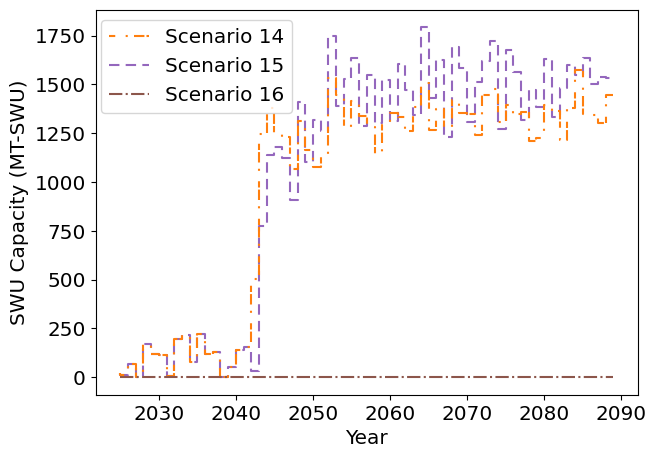

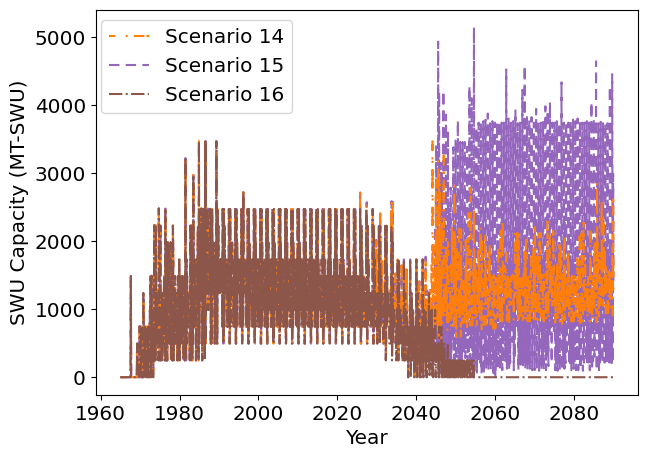

In [17]:
for key in ['s15','s14','s16']:
    if key == 's16':
        AR_swu = SWU_nogrowth[key + '_SFR'].copy()
    else:
        AR_swu = SWU_nogrowth[key + '_MMR'].copy()
        for reactor in ['Xe-100','VOYGR']:
            AR_swu += SWU_nogrowth[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_swu[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    ax0=plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    
    total_swu = AR_swu + SWU_nogrowth[key + '_LWR']
    ax1=plt.figure(1)
    plt.plot(uranium_to_reactors[key + '_LWR']['Year'], total_swu/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')

handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax0.savefig("figures/nogrowth_recycle_AR_swu.pdf", bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax1.savefig("figures/nogrowth_recycle_swu.pdf", bbox_inches='tight')

In [18]:
#Reporting SWU Requirements
for scenario in transactions_nogrowth:
    if scenario == 's16':
        HALEU_SWU = SWU_nogrowth[scenario+'_SFR']
        AR_SWU = HALEU_SWU
    else:
        HALEU_SWU = SWU_nogrowth[scenario+'_MMR'] + SWU_nogrowth[scenario+'_Xe-100']
        AR_SWU = HALEU_SWU + SWU_nogrowth[scenario+'_VOYGR']
    print('Average HALEU SWU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    print('Average SWU in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum SWU in ', scenario, ':', AR_SWU[721:].max()/1000)

Average HALEU SWU in s14 after 2025: 965.8934985671772
Average SWU in  s14 : 971.644353660045
Maximum SWU in  s14 : 3032.6509215609617
Average HALEU SWU in s15 after 2025: 1036.1289761126852
Average SWU in  s15 : 1041.8798312055528
Maximum SWU in  s15 : 5142.3253425093735
Average HALEU SWU in s16 after 2025: 0.0
Average SWU in  s16 : 0.0
Maximum SWU in  s16 : 0.0


### Waste and SNF masses

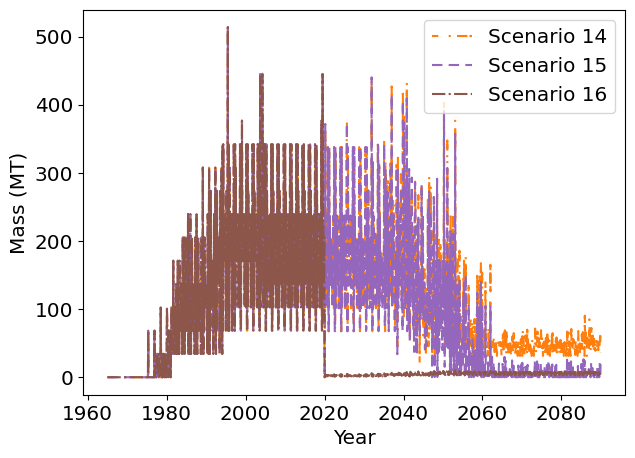

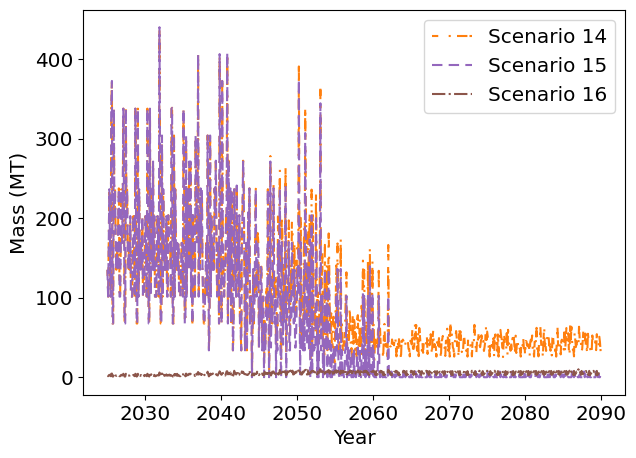

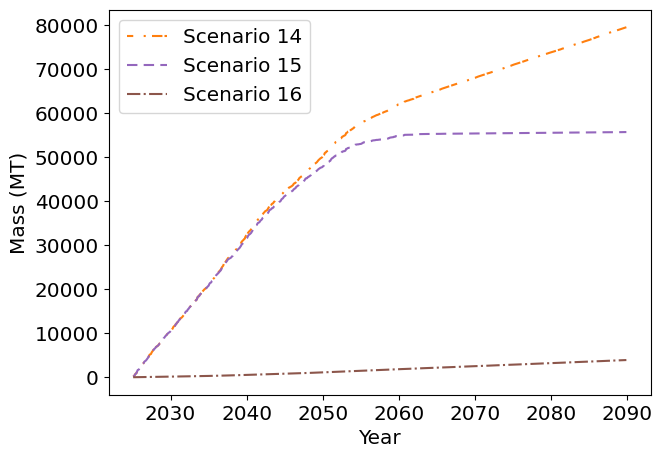

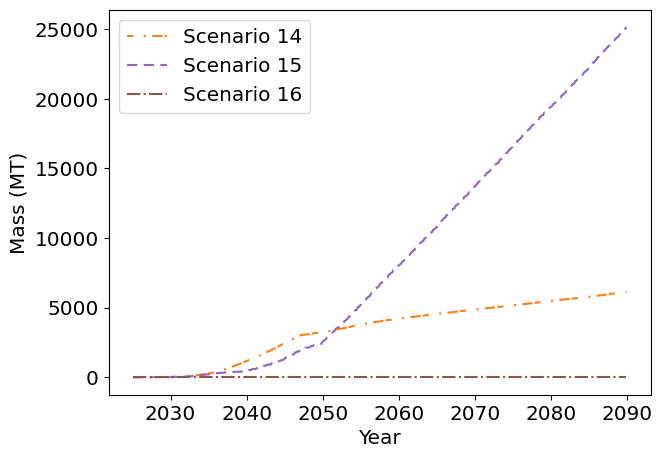

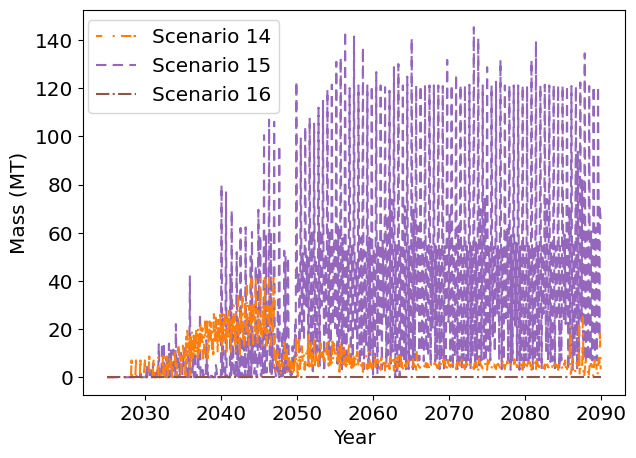

In [19]:
total_waste = {'s14':'', 's15':'', 's16':''} # all material sent to repository
mox_waste = {'s14':'', 's15':'', 's16':''} # spent MOX assemblies sent to repository
separations_waste = {'s14':'', 's15':'', 's16':''} # Separated waste, HLW
transition_waste = {'s14':'', 's15':'', 's16':''} # MOX and Separated waste (SNF + HLW)
snf_waste = {'s14':'', 's15':'', 's16':''}

for key in total_waste:
    total_waste[key] = dfa.transactions_to_prototype(transactions_nogrowth[key], 'Sink_HLW')
    LWR_waste = dfa.transactions_to_prototype(transactions_nogrowth[key], 'Sink_LWR_UOX')
    total_waste[key]['Quantity'] += LWR_waste['Quantity']

    separations_waste[key] = dfa.commodity_to_prototype(transactions_nogrowth[key], 'separated_waste', 'Sink_HLW')
    mox_waste[key] = dfa.commodity_to_prototype(transactions_nogrowth[key], 'cool_spent_mox', 'Sink_HLW')
    transition_waste[key] = separations_waste[key]['Quantity'] + mox_waste[key]['Quantity']
    snf_waste[key] = mox_waste[key]['Quantity']
    if key == 's15':
        mmr_waste = dfa.commodity_to_prototype(transactions_nogrowth[key], 'cool_MMR_uox', 'Sink_HLW')
        #xe100_waste = dfa.commodity_to_prototype(transactions_nogrowth[key], 'cool_xe100_uox','SinkHLW')
        # For some reason the spent Xe-100 fuel isn't sent from the Xe100_UOX_Cooling agents to the 
        # Sink_HLW agents. Approximating this by getting the mass of spent Xe-100 fuel sent from 
        # Xe-100 agents to the Xe100_UOX_Cooling agents. 
        xe100_waste = dfa.commodity_to_prototype(transactions_nogrowth['s15'], 'spent_xe100_uox', 'Xe100_UOX_Cooling')
        snf_waste[key] += mmr_waste['Quantity'] + xe100_waste['Quantity']

    # all waste and SNF
    ax0=plt.figure(0)
    plt.plot(total_waste[key]['Year'], total_waste[key]['Quantity']/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/nogrowth_recycle_totalwaste.pdf")
    
    # Separated fissile material, HLW
    ax2=plt.figure(2)
    plt.plot(separations_waste[key]['Year'][721:], separations_waste[key]['Quantity'][721:]/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/nogrowth_recycle_hlw.pdf")

    # Cumulative SNF + HLW from non-LWRs
    ax5=plt.figure(5)
    plt.plot(separations_waste[key]['Year'][721:], transition_waste[key][721:].cumsum()/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/nogrowth_recycle_snf_hlw_cumulative.pdf")

    ax7=plt.figure(7)
    plt.plot(separations_waste[key]['Year'][721:], snf_waste[key][721:].cumsum()/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/nogrowth_recycle_snf_cumulative.pdf")

for key in ['s15','s14','s16']:
    # all SNF waste disposed of, MOX + LWR SNF
    ax6=plt.figure(6)
    plt.plot(separations_waste[key]['Year'][721:], snf_waste[key][721:]/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')

handles, legend_labels = ax6.gca().get_legend_handles_labels()
ax6.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax6.savefig("figures/nogrowth_recycle_snf.pdf", bbox_inches='tight')

In [20]:
#Reporting waste masses
for scenario in transactions_nogrowth:
    print('Average SNF waste in', scenario, 'after 2025:', snf_waste[scenario][721:].mean()/1000)
    print('Maxmum SNF waste in', scenario, 'after 2025:', snf_waste[scenario][721:].max()/1000)
    print('Cumulative SNF waste in', scenario, 'after 2025:', snf_waste[scenario][721:].cumsum()[1499]/1000)
    print('Average HLW waste in', scenario, 'after 2025:', separations_waste[scenario]['Quantity'][721:].mean()/1000)
    print('Maximum HLW in', scenario, 'after 2025:', separations_waste[scenario]['Quantity'][721:].max()/1000)
    print('Cumulative HLW in', scenario, 'after 2025:', separations_waste[scenario]['Quantity'][721:].cumsum()[1499]/1000)
    

Average SNF waste in s14 after 2025: 7.834897458279843
Maxmum SNF waste in s14 after 2025: 41.33343999999991
Cumulative SNF waste in s14 after 2025: 6103.385120000014
Average HLW waste in s14 after 2025: 94.20945791017101
Maximum HLW in s14 after 2025: 440.17397865019615
Cumulative HLW in s14 after 2025: 73389.16771202328
Average SNF waste in s15 after 2025: 32.28887148395378
Maxmum SNF waste in s15 after 2025: 145.38009599999998
Cumulative SNF waste in s15 after 2025: 25153.030885999993
Average HLW waste in s15 after 2025: 67.73407990192864
Maximum HLW in s15 after 2025: 440.17397865019615
Cumulative HLW in s15 after 2025: 52764.84824360264
Average SNF waste in s16 after 2025: 0.0
Maxmum SNF waste in s16 after 2025: 0.0
Cumulative SNF waste in s16 after 2025: 0.0
Average HLW waste in s16 after 2025: 5.010623489862993
Maximum HLW in s16 after 2025: 10.09343608545215
Cumulative HLW in s16 after 2025: 3903.275698603273


### Separated Pu

In [21]:
sep_pu = {'s14':'', 's15':'', 's16':''}
transactions_senders = {'s14':'', 's15':'', 's16':''}
for key in sep_pu:
    transactions_senders[key] = tm.add_sender_prototype(out_files[key])
    sep_pu[key] = dfa.commodity_from_prototype(transactions_senders[key],
                                               'separated_fissile',
                                               'SeparationsFacility')

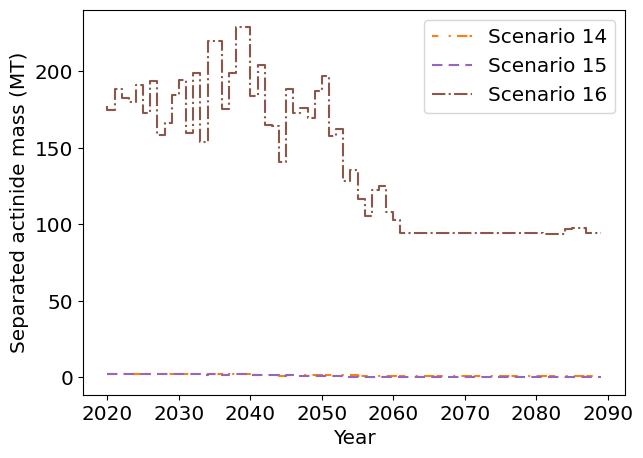

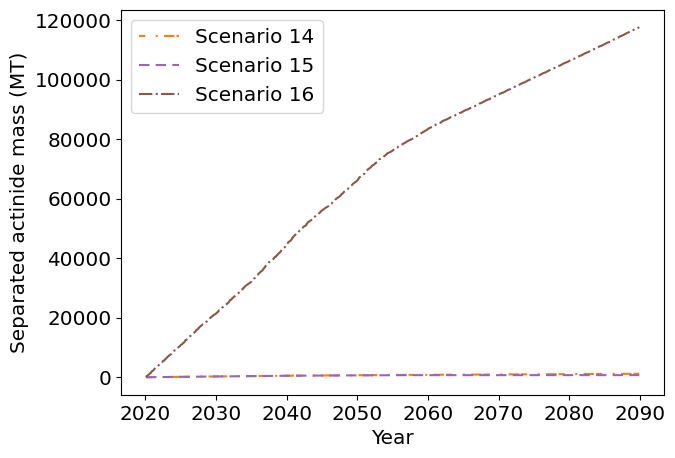

In [23]:
for key in transactions_senders:
    counter = 661
    averages = []
    for ii in range(0, 70):
        year_data = sep_pu[key]['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2020, 2089, 70), averages, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Separated actinide mass (MT)')
    plt.legend()
    plt.savefig("figures/nogrowth_recycle_sep_pu.pdf")
    
    plt.figure(2)
    plt.plot(sep_pu[key]['Year'][661:], sep_pu[key]['Quantity'][661:].cumsum()/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Separated actinide mass (MT)')
    plt.legend()
    plt.savefig("figures/nogrowth_recycle_sep_pu_cumulative.pdf")

In [24]:
#reporting seaparated Pu masses
for scenario in transactions_senders:
    print('Average Sep Pu in', scenario, 'after 2020:', sep_pu[scenario]['Quantity'][661:].mean()/1000)
    print('Maximum  Sep Pu in', scenario, ':', sep_pu[scenario]['Quantity'][661:].max()/1000)
    print('Cumulative Sep Pu in', scenario, ':', sep_pu[scenario]['Quantity'][661:].cumsum()[1499]/1000)

Average Sep Pu in s14 after 2020: 1.3716078550838726
Maximum  Sep Pu in s14 : 4.734735042744031
Cumulative Sep Pu in s14 : 1150.7789904153685
Average Sep Pu in s15 after 2020: 0.8402294527249374
Maximum  Sep Pu in s15 : 4.734735042744031
Cumulative Sep Pu in s15 : 704.9525108362263
Average Sep Pu in s16 after 2020: 140.14796131741954
Maximum  Sep Pu in s16 : 454.3196487699934
Cumulative Sep Pu in s16 : 117584.13954531473


## 1% growth scenarios

In [25]:
transactions_1percent = {'s17':'', 's18':'', 's19':''}
for scenario in transactions_1percent:
    transactions_1percent[scenario] = tm.add_receiver_prototype(out_files[scenario])

### Reactor numbers 

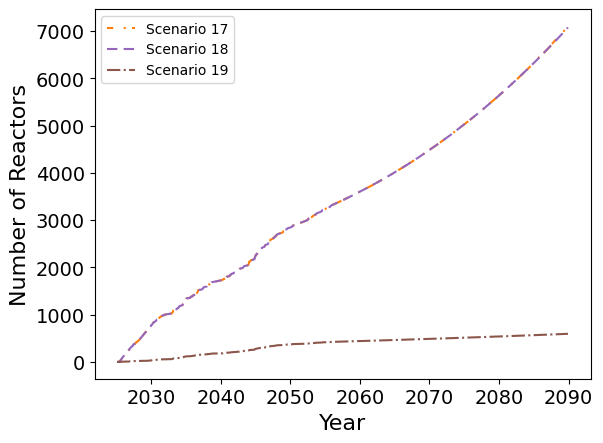

In [3]:
reactors_1percent = {'s17':'','s18':'','s19':''}
plt.figure(0)
for scenario in reactors_1percent:
    reactors_1percent[scenario] = tm.get_prototype_totals(out_files[scenario], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[scenario]['Year'][721:], reactors_1percent[scenario]['advrx_total'][721:], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/1percent_recycle_reactors.pdf', bbox_inches='tight')

In [4]:
for scenario in reactors_1percent:
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in {scenario}:', reactors_1percent[scenario][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in {scenario}:', reactors_1percent[scenario][adv_rx +'_enter'].max())
        prototype_sum = reactors_1percent[scenario][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in {scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in {scenario}:', reactors_1percent[scenario]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in {scenario}:', reactors_1percent[scenario]['advrx_enter'].max())
    advrx_sum = reactors_1percent[scenario]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in {scenario}:', advrx_sum.iloc[-1])  

Max MMR in s17: 5228.0
Max MMR added in one step in s17: 46.0
Total number of MMR deployed in s17: 10363.0
Max Xe-100 in s17: 1837.0
Max Xe-100 added in one step in s17: 47.0
Total number of Xe-100 deployed in s17: 1867.0
Max VOYGR in s17: 42.0
Max VOYGR added in one step in s17: 1.0
Total number of VOYGR deployed in s17: 43.0
Max SFR in s17: 0.0
Max SFR added in one step in s17: 0.0
Total number of SFR deployed in s17: 0.0
Max Adv Rx in s17: 7107.0
Max Adv Rx added in one step in s17: 58.0
Total number of reactors deployed in s17: 12273.0
Max MMR in s18: 5228.0
Max MMR added in one step in s18: 46.0
Total number of MMR deployed in s18: 10363.0
Max Xe-100 in s18: 1809.0
Max Xe-100 added in one step in s18: 47.0
Total number of Xe-100 deployed in s18: 1867.0
Max VOYGR in s18: 37.0
Max VOYGR added in one step in s18: 1.0
Total number of VOYGR deployed in s18: 43.0
Max SFR in s18: 0.0
Max SFR added in one step in s18: 0.0
Total number of SFR deployed in s18: 0.0
Max Adv Rx in s18: 7074.0


### Fuel Mass

In [26]:
# Divide up fuel mass by prototype
uranium_to_reactors_1percent = {'s17_MMR':'', 's17_Xe-100':'', 's17_VOYGR':'', 's17_SFR':'', 's17_LWR':'',
                                's18_MMR':'', 's18_Xe-100':'', 's18_VOYGR':'', 's18_SFR':'', 's18_LWR':'',
                                's19_MMR':'', 's19_Xe-100':'', 's19_VOYGR':'', 's19_SFR':'', 's19_LWR':''}
mox_to_reactors_1percent = { 's17_Xe-100':'', 's17_VOYGR':'', 's17_SFR':'', 
                             's18_Xe-100':'', 's18_VOYGR':'', 's18_SFR':'', 
                             's19_Xe-100':'', 's19_VOYGR':'', 's19_SFR':''}

for key in uranium_to_reactors_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors_1percent[key] = dfa.commodity_to_LWR(transactions_1percent[scenario], 
                                                       'fresh_uox',adv_rxs)
    else:
        uranium_to_reactors_1percent[key] = dfa.commodity_to_prototype(transactions_1percent[scenario], 
                                                       uox_commodity[reactor], reactor)
        uranium_to_reactors_1percent[key]['Quantity'] = uranium_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor]
    if reactor == 'Xe-100' or reactor == 'VOYGR' or reactor == 'SFR':
            mox_to_reactors_1percent[key] = dfa.commodity_to_prototype(transactions_1percent[scenario],
                                                     mox_commodity[reactor], reactor)


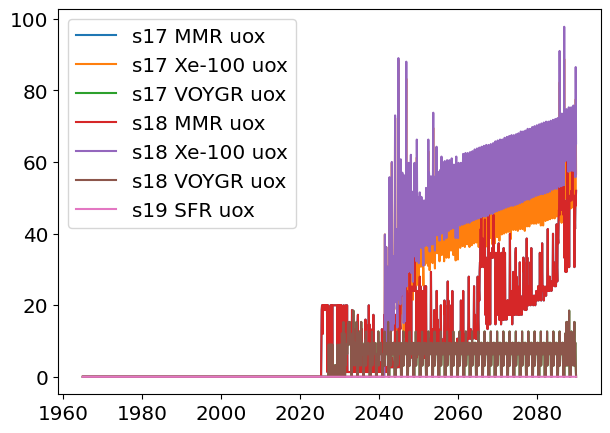

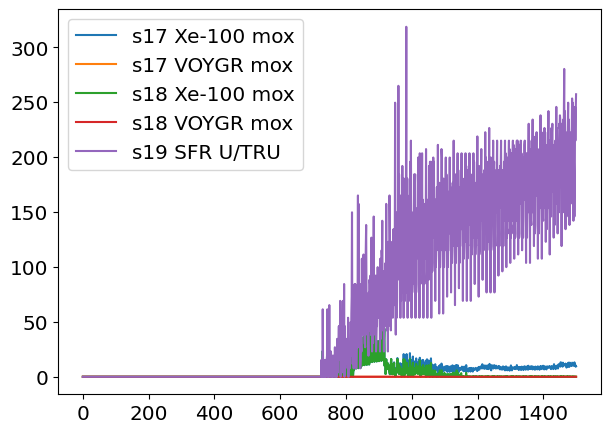

In [27]:
for scenario in transactions_1percent:
    plt.figure(0)
    if scenario == 's19':
        plt.plot(uranium_to_reactors_1percent[scenario + '_SFR']['Year'],
                 uranium_to_reactors_1percent[scenario + '_SFR']['Quantity']/1000, label = (scenario + ' SFR uox'))
    else:
        for reactor in ['MMR', 'Xe-100','VOYGR']:
            plt.plot(uranium_to_reactors_1percent[scenario + '_' + reactor]['Year'],
                     uranium_to_reactors_1percent[scenario + '_' + reactor]['Quantity']/1000, label = (scenario + ' ' + reactor+' uox'))
    plt.legend()

    plt.figure(1)
    if scenario == 's19':
        plt.plot(mox_to_reactors_1percent[scenario + '_SFR']['Quantity']/1000, label = (scenario + ' SFR U/TRU'))
    else:
        for reactor in ['Xe-100', 'VOYGR']:
            plt.plot(mox_to_reactors_1percent[scenario + '_' + reactor]['Quantity']/1000, label = (scenario + ' ' + reactor+' mox'))
    plt.legend()

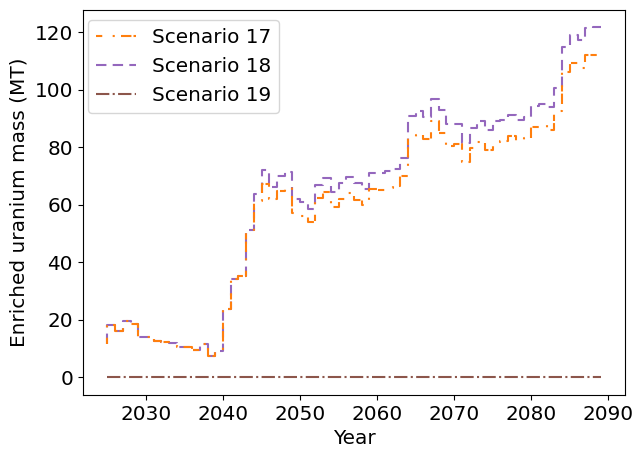

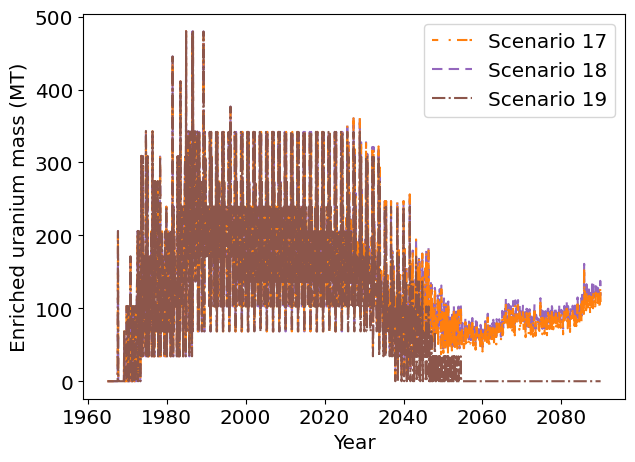

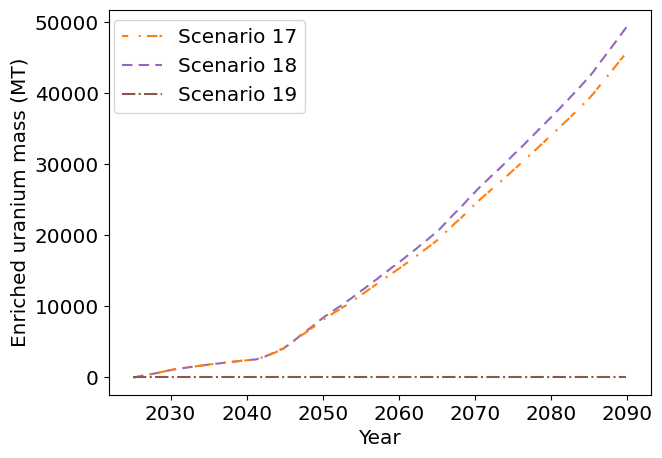

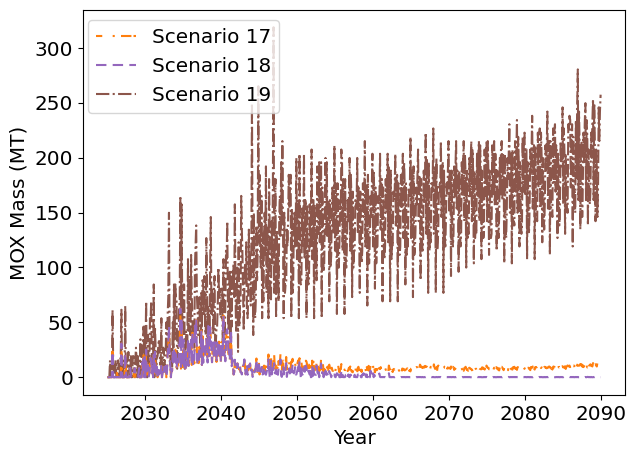

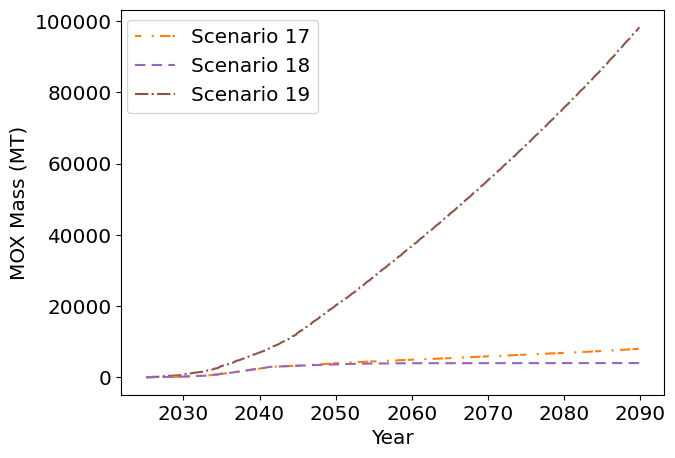

In [28]:
for key in ['s18','s17','s19']:
    AR_uranium = uranium_to_reactors_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_1percent[key + '_' + reactor]['Quantity']
    averages = []
    counter = 721
    for ii in range(0, 65):
        year_data = AR_uranium['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter +=12
        
    ax0 = plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key], 
            color =colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    
    total_uranium = AR_uranium['Quantity'] + uranium_to_reactors_1percent[key + '_LWR']['Quantity']
    ax1 = plt.figure(1)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], total_uranium/1000, 
            label = labels[key], color = colors[key], linestyle=lines[key]) 
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    
    ax2 = plt.figure(2)
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')

for key in ['s19','s17','s18']:
    total_mox = mox_to_reactors_1percent[key+'_Xe-100']['Quantity'] + mox_to_reactors_1percent[key+'_VOYGR']['Quantity'] + \
                mox_to_reactors_1percent[key+'_SFR']['Quantity']
    ax3 = plt.figure(3)
    plt.plot(mox_to_reactors_1percent[key+'_Xe-100']['Year'][721:], total_mox[721:]/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('MOX Mass (MT)')

    ax4 = plt.figure(4)
    plt.plot(mox_to_reactors_1percent[key+'_Xe-100']['Year'][721:], total_mox[721:].cumsum()/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('MOX Mass (MT)')

handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax0.savefig("figures/1percent_recycle_Uaverages.pdf", bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]],bbox_to_anchor=(0.9,0.88))
ax1.savefig("figures/1percent_recycle_total_fuel.pdf", bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in [1,0,2]],[legend_labels[idx] for idx in [1,0,2]], bbox_to_anchor=(0.42, 0.88))
ax2.savefig("figures/1percent_recycle_Ucumulative.pdf", bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in [1,2,0]],[legend_labels[idx] for idx in [1,2,0]], bbox_to_anchor=(0.42, 0.88))
ax3.savefig("figures/1percent_recycle_MOX.pdf", bbox_inches='tight')
handles, legend_labels = ax4.gca().get_legend_handles_labels()
ax4.legend([handles[idx] for idx in [1,2,0]],[legend_labels[idx] for idx in [1,2,0]], bbox_to_anchor=(0.42, 0.88))
ax4.savefig("figures/1percent_recycle_MOXcumulative.pdf", bbox_inches='tight')

In [29]:
#Reporting UOX masses
for scenario in transactions_1percent:
    if scenario == 's19':
        HALEU_mass = uranium_to_reactors_1percent[scenario+'_SFR']
        AR_mass = HALEU_mass
    else:
        HALEU_mass = uranium_to_reactors_1percent[scenario+'_MMR'] + uranium_to_reactors_1percent[scenario+'_Xe-100']
        AR_mass = HALEU_mass + uranium_to_reactors_1percent[scenario+'_VOYGR']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:]['Quantity'].mean()/1000)
    print('Average mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].mean()/1000)
    print('Maximum mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].max()/1000)
    print('Cumulative mass in', scenario, 'after 2025:',AR_mass[721:]['Quantity'].cumsum()[1499]/1000)

Average HALEU mass in s17 after 2025: 52.811370338135504
Average mass in s17 after 2025: 58.71897317034192
Maximum mass in s17 after 2025: 152.174197805318
Cumulative mass in s17 after 2025: 45742.08009969634
Average HALEU mass in s18 after 2025: 57.41696085185205
Average mass in s18 after 2025: 63.32456368405847
Maximum mass in s18 after 2025: 160.92542962331797
Cumulative mass in s18 after 2025: 49329.83510988154
Average HALEU mass in s19 after 2025: 0.0
Average mass in s19 after 2025: 0.0
Maximum mass in s19 after 2025: 0.0
Cumulative mass in s19 after 2025: 0.0


In [30]:
#Reporting MOX/U-TRU masses
for scenario in transactions_1percent:
    if scenario == 's19':
        MOX_mass = mox_to_reactors_1percent[scenario+'_SFR']
    else:
        MOX_mass = mox_to_reactors_1percent[scenario+'_VOYGR'] + mox_to_reactors_1percent[scenario+'_Xe-100']
    print('Average MOX mass in', scenario,'after 2025:', MOX_mass[721:]['Quantity'].mean()/1000)
    print('Maximum MOX mass in', scenario, 'after 2025:', 
          MOX_mass[721:]['Quantity'].max()/1000)
    print('Cumulative MOX mass in', scenario, 'after 2025:',MOX_mass[721:]['Quantity'].cumsum()[1499]/1000)

Average MOX mass in s17 after 2025: 10.25305355584082
Maximum MOX mass in s17 after 2025: 62.558719999999994
Cumulative MOX mass in s17 after 2025: 7987.128719999986
Average MOX mass in s18 after 2025: 5.108780487804877
Maximum MOX mass in s18 after 2025: 62.558719999999994
Cumulative MOX mass in s18 after 2025: 3979.7399999999725
Average MOX mass in s19 after 2025: 126.21720154043645
Maximum MOX mass in s19 after 2025: 318.72
Cumulative MOX mass in s19 after 2025: 98323.2


### Natural uranium masses

In [31]:
tails_1percent = {'s17_MMR':'', 's17_Xe-100':'', 's17_VOYGR':'', 's17_SFR':'', 's17_LWR':'',
                                's18_MMR':'', 's18_Xe-100':'', 's18_VOYGR':'', 's18_SFR':'', 's18_LWR':'',
                                's19_MMR':'', 's19_Xe-100':'', 's19_VOYGR':'', 's19_SFR':'', 's19_LWR':''}
feed_1percent = {'s17_MMR':'', 's17_Xe-100':'', 's17_VOYGR':'', 's17_SFR':'', 's17_LWR':'',
                                's18_MMR':'', 's18_Xe-100':'', 's18_VOYGR':'', 's18_SFR':'', 's18_LWR':'',
                                's19_MMR':'', 's19_Xe-100':'', 's19_VOYGR':'', 's19_SFR':'', 's19_LWR':''}
SWU_1percent = {'s17_MMR':'', 's17_Xe-100':'', 's17_VOYGR':'', 's17_SFR':'', 's17_LWR':'',
                                's18_MMR':'', 's18_Xe-100':'', 's18_VOYGR':'', 's18_SFR':'', 's18_LWR':'',
                                's19_MMR':'', 's19_Xe-100':'', 's19_VOYGR':'', 's19_SFR':'', 's19_LWR':''}
nat_u_1percent = {'s17_Xe-100':'', 's17_VOYGR':'', 
                   's18_Xe-100':'', 's18_VOYGR':'',
                   's19_SFR':''}
for key in tails_1percent:
    reactor = key[4:]
    tails_1percent[key] = dfa.calculate_tails(uranium_to_reactors_1percent[key]['Quantity'],
                                    assays[reactor], assays['tails'], assays['feed'])
    feed_1percent[key] = dfa.calculate_feed(uranium_to_reactors_1percent[key]['Quantity'],
                                  tails_1percent[key])
    SWU_1percent[key] = dfa.calculate_SWU(uranium_to_reactors_1percent[key]['Quantity'], assays[reactor],
                                tails_1percent[key], assays['tails'], feed_1percent[key], assays['feed'])
    if reactor in ['Xe-100', 'VOYGR','SFR']:
        nat_u_1percent[key] = natu_fractions[reactor]*mox_to_reactors_1percent[key]['Quantity']

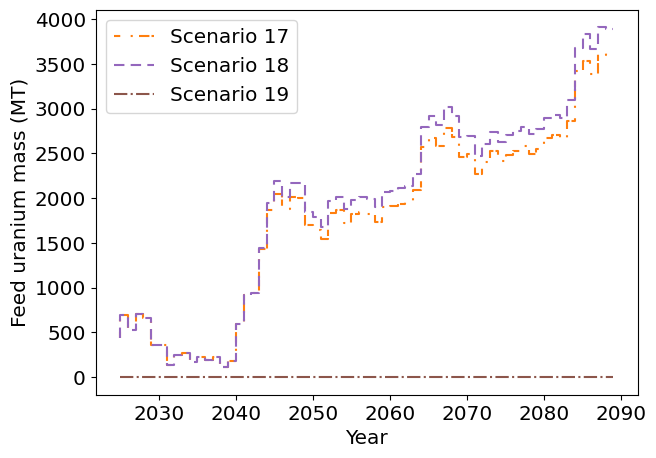

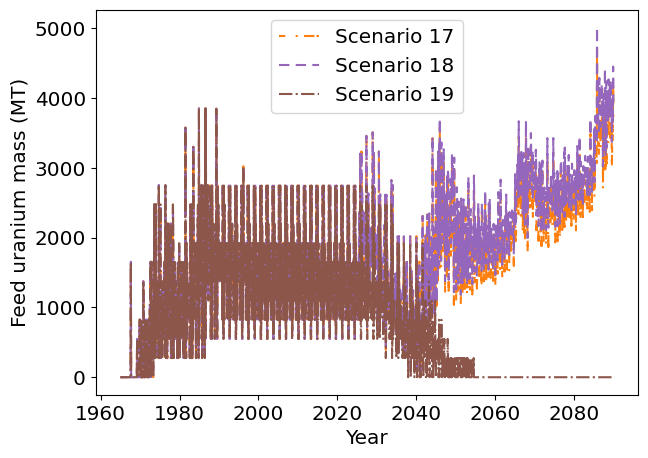

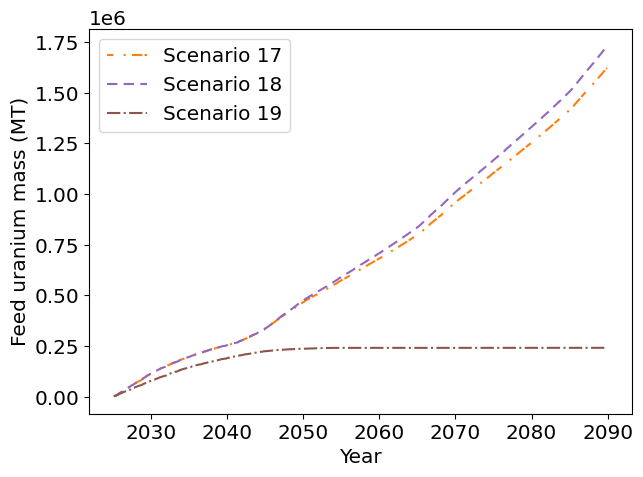

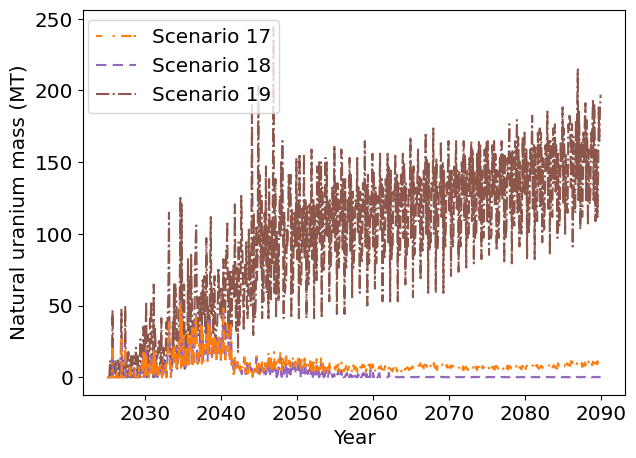

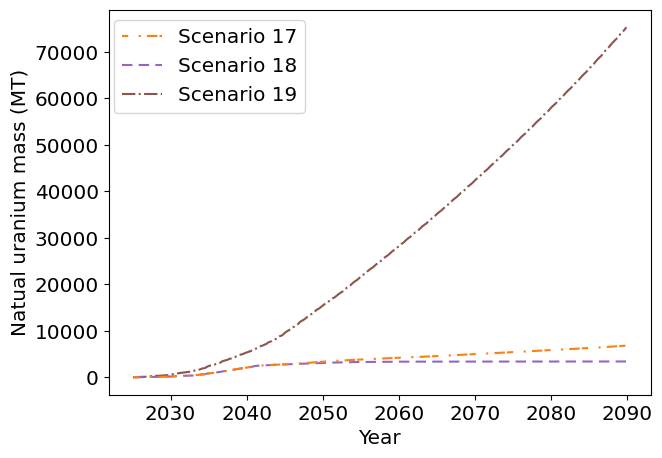

In [32]:
# Feed uranium
for key in transactions_1percent:
    AR_feed = feed_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_1percent[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_feed[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_feed_average.pdf", bbox_inches='tight')
    
    total_feed = AR_feed + feed_1percent[key + '_LWR']
    plt.figure(1)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], total_feed/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_feed.pdf", bbox_inches='tight')
    
    
    plt.figure(2)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'][721:], total_feed[721:].cumsum()/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_feed_cumulative.pdf", bbox_inches='tight')

for key in ['s19','s18','s17']:
    if key == 's19':
        nat_u = nat_u_1percent['s19_SFR']
    else:
        nat_u = nat_u_1percent[key + '_Xe-100'] + nat_u_1percent[key + '_VOYGR']    
    #nat U for MOX/U-TRU
    ax3=plt.figure(3)
    plt.plot(uranium_to_reactors_1percent[key + '_LWR']['Year'][721:], nat_u[721:]/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Natural uranium mass (MT)')

    #cumulative nat U for MOX/U-TRU
    ax4=plt.figure(4)
    plt.plot(uranium_to_reactors_1percent[key + '_LWR']['Year'][721:], nat_u[721:].cumsum()/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Natual uranium mass (MT)')

handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in [2,1,0]],[legend_labels[idx] for idx in [2,1,0]], bbox_to_anchor=(0.42, 0.88))
ax3.savefig("figures/1percent_recycle_natU.pdf", bbox_inches='tight')
handles, legend_labels = ax4.gca().get_legend_handles_labels()
ax4.legend([handles[idx] for idx in [2,1,0]],[legend_labels[idx] for idx in [2,1,0]], bbox_to_anchor=(0.42, 0.88))
ax4.savefig("figures/1percent_recycle_natU_cumulative.pdf", bbox_inches='tight')

In [33]:
#Reporting feed masses
for scenario in transactions_1percent:
    if scenario == 's16':
        HALEU_feed = feed_1percent[scenario+'_SFR']   
        AR_feed = HALEU_feed
    else:
        HALEU_feed = feed_1percent[scenario+'_MMR'] + feed_1percent[scenario+'_Xe-100']
        AR_feed = HALEU_feed + feed_1percent[scenario+'_VOYGR']
    print('Average feed for HALEU in',scenario, 'after 2025:', HALEU_feed[721:].mean()/1000)
    print('AR Average mass in', scenario, 'after 2025:', AR_feed[721:].mean()/1000)
    print('AR Maximum mass in', scenario, 'after 2025:', AR_feed[721:].max()/1000)
    print('AR Cumulative mass in', scenario, 'after 2025:', AR_feed[721:].cumsum()[1499]/1000)

Average feed for HALEU in s17 after 2025: 1728.584476182209
AR Average mass in s17 after 2025: 1773.5562472532133
AR Maximum mass in s17 after 2025: 4750.140948405914
AR Cumulative mass in s17 after 2025: 1381600.3166102539
Average feed for HALEU in s18 after 2025: 1866.4818046750925
AR Average mass in s18 after 2025: 1911.4535757460965
AR Maximum mass in s18 after 2025: 5012.164131997694
AR Cumulative mass in s18 after 2025: 1489022.3355062094
Average feed for HALEU in s19 after 2025: 0.0
AR Average mass in s19 after 2025: 0.0
AR Maximum mass in s19 after 2025: 0.0
AR Cumulative mass in s19 after 2025: 0.0


In [34]:
#Reporting nat U masses
for scenario in transactions_1percent:
    if scenario == 's19':  
        nat_u = nat_u_1percent['s19_SFR']
    else:
        nat_u = nat_u_1percent[scenario + '_Xe-100'] + nat_u_1percent[scenario + '_VOYGR']
    print('Average nat U in',scenario, 'after 2025:', nat_u[721:].mean()/1000)
    print('Nat U Maximum mass in', scenario, 'after 2025:', nat_u[721:].max()/1000)
    print('Nat U Cumulative mass in', scenario, 'after 2025:', nat_u[721:].cumsum()[1499]/1000)

Average nat U in s17 after 2025: 8.72586122869833
Nat U Maximum mass in s17 after 2025: 53.240598655999996
Nat U Cumulative mass in s17 after 2025: 6797.445897156
Average nat U in s18 after 2025: 4.34782763414634
Nat U Maximum mass in s18 after 2025: 53.240598655999996
Nat U Cumulative mass in s18 after 2025: 3386.957726999975
Average nat U in s19 after 2025: 96.66723031578947
Nat U Maximum mass in s19 after 2025: 244.1012736
Nat U Cumulative mass in s19 after 2025: 75303.772416


### SWU

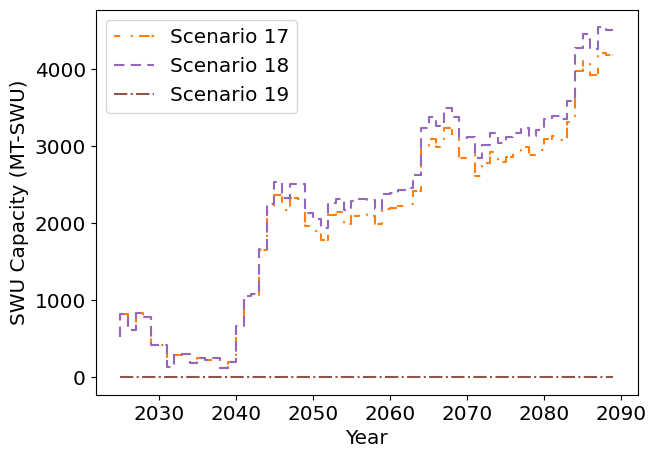

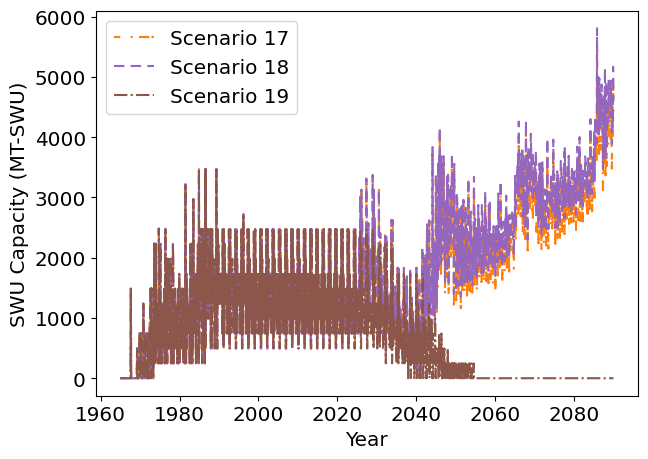

In [35]:
for key in transactions_1percent:
    AR_swu = SWU_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_swu += SWU_1percent[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_swu[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_AR_swu.pdf", bbox_inches='tight')
    
    total_swu = AR_swu + SWU_1percent[key + '_LWR']
    plt.figure(1)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], total_swu/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_swu.pdf", bbox_inches='tight')

In [36]:
#Reporting SWU Requirements
for scenario in transactions_1percent:
    if scenario == 's19':
        HALEU_SWU = SWU_1percent[scenario+'_SFR']
        AR_SWU = HALEU_SWU
    else:
        HALEU_SWU = SWU_1percent[scenario+'_MMR'] + SWU_1percent[scenario+'_Xe-100']
        AR_SWU = HALEU_SWU + SWU_1percent[scenario+'_VOYGR']
    print('Average HALEU SWU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    print('Average SWU in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum SWU in ', scenario, ':', AR_SWU[721:].max()/1000)



Average HALEU SWU in s17 after 2025: 2009.0930047140153
Average SWU in  s17 : 2048.9633522248464
Maximum SWU in  s17 : 5504.684685721238
Average HALEU SWU in s18 after 2025: 2167.853065725435
Average SWU in  s18 : 2207.7234132362664
Maximum SWU in  s18 : 5806.349823603762
Average HALEU SWU in s19 after 2025: 0.0
Average SWU in  s19 : 0.0
Maximum SWU in  s19 : 0.0


### Waste mass -- disposed of in HLW Sink

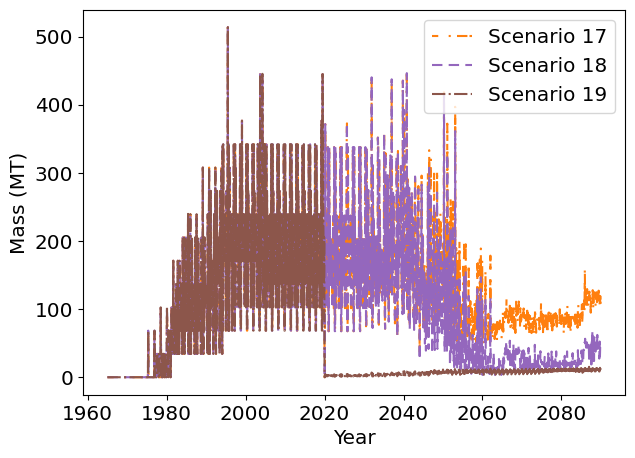

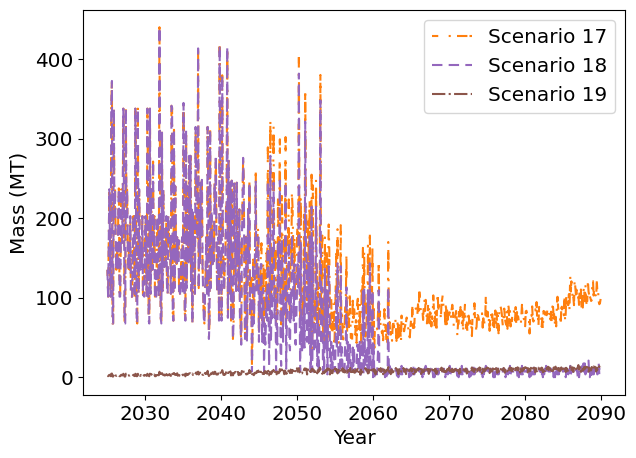

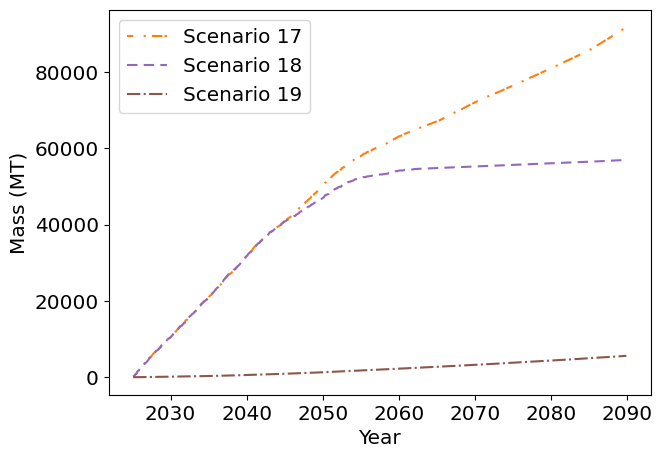

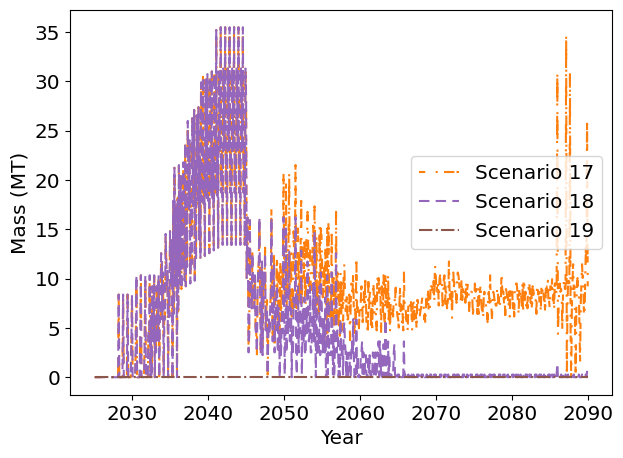

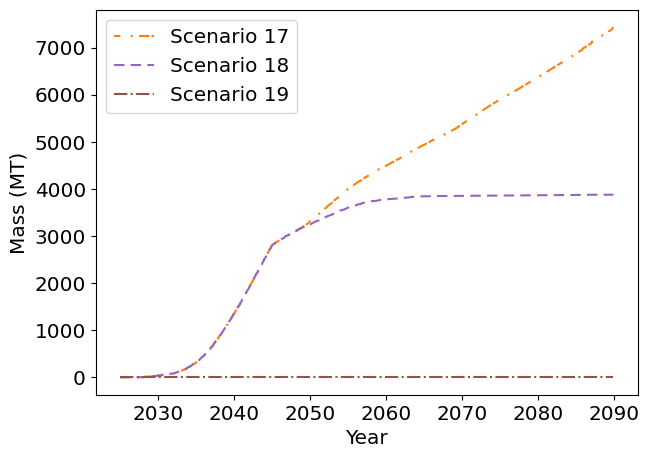

In [38]:
total_waste_1percent = {'s17':'', 's18':'','s19':''} # all material sent to repository
mox_waste_1percent = {'s17':'', 's18':'','s19':''} # spent MOX assemblies sent to repository
separations_waste_1percent = {'s17':'', 's18':'','s19':''} # Separated waste, HLW
transition_waste_1percent = {'s17':'', 's18':'','s19':''}  # MOX and Separated waste (SNF + HLW)
snf_waste_1percent = {'s17':'', 's18':'','s19':''} 

for key in total_waste_1percent:
    total_waste_1percent[key] = dfa.transactions_to_prototype(transactions_1percent[key], 'Sink_HLW')
    LWR_waste = dfa.transactions_to_prototype(transactions_1percent[key], 'Sink_LWR_UOX')
    total_waste_1percent[key]['Quantity'] += LWR_waste['Quantity']

    separations_waste_1percent[key] = dfa.commodity_to_prototype(transactions_1percent[key], 'separated_waste', 'Sink_HLW')
    mox_waste_1percent[key] = dfa.commodity_to_prototype(transactions_1percent[key], 'cool_spent_mox', 'Sink_HLW')
    transition_waste_1percent[key] = separations_waste_1percent[key]['Quantity'] + mox_waste_1percent[key]['Quantity']
    snf_waste_1percent[key] = mox_waste_1percent[key]['Quantity'] + LWR_waste['Quantity']
        

    # all waste and SNF
    plt.figure(0)
    plt.plot(total_waste_1percent[key]['Year'], total_waste_1percent[key]['Quantity']/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_totalwaste.pdf")

    # Separated fissile material, HLW
    plt.figure(2)
    plt.plot(separations_waste_1percent[key]['Year'][721:], separations_waste_1percent[key]['Quantity'][721:]/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_hlw.pdf")

    # Cumulative  HLW from non-LWRs
    plt.figure(3)
    plt.plot(separations_waste_1percent[key]['Year'][721:], separations_waste_1percent[key]['Quantity'][721:].cumsum()/1000, 
             label=labels[key], color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_hlw_cumulative.pdf")
    

    # all SNF waste disposed of, MOX + LWR SNF
    plt.figure(6)
    plt.plot(separations_waste_1percent[key]['Year'][721:], snf_waste_1percent[key][721:]/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_snf.pdf")

    plt.figure(7)
    plt.plot(separations_waste_1percent[key]['Year'][721:], snf_waste_1percent[key][721:].cumsum()/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_snf_cumulative.pdf")

In [39]:
#Reporting waste masses
for scenario in transactions_1percent:
    print('Average SNF waste in', scenario, 'after 2025:', snf_waste_1percent[scenario][721:].mean()/1000)
    print('Maxmum SNF waste in', scenario, 'after 2025:', snf_waste_1percent[scenario][721:].max()/1000)
    print('Cumulative SNF waste in', scenario, 'after 2025:', snf_waste_1percent[scenario][721:].cumsum()[1499]/1000)
    print('Average HLW waste in', scenario, 'after 2025:', separations_waste_1percent[scenario]['Quantity'][721:].mean()/1000)
    print('Maximum HLW in', scenario, 'after 2025:', separations_waste_1percent[scenario]['Quantity'][721:].max()/1000)
    print('Cumulative HLW in', scenario, 'after 2025:', separations_waste_1percent[scenario]['Quantity'][721:].cumsum()[1499]/1000)
    

Average SNF waste in s17 after 2025: 9.542126418485232
Maxmum SNF waste in s17 after 2025: 35.46855999999993
Cumulative SNF waste in s17 after 2025: 7433.316479999987
Average HLW waste in s17 after 2025: 117.67747895331053
Maximum HLW in s17 after 2025: 440.17397865019615
Cumulative HLW in s17 after 2025: 91670.75610462892
Average SNF waste in s18 after 2025: 4.977924005134785
Maxmum SNF waste in s18 after 2025: 35.46855999999993
Cumulative SNF waste in s18 after 2025: 3877.8027999999745
Average HLW waste in s18 after 2025: 73.06148965190874
Maximum HLW in s18 after 2025: 440.1739786501962
Cumulative HLW in s18 after 2025: 56914.90043883655
Average SNF waste in s19 after 2025: 0.0
Maxmum SNF waste in s19 after 2025: 0.0
Cumulative SNF waste in s19 after 2025: 0.0
Average HLW waste in s19 after 2025: 7.194545373892573
Maximum HLW in s19 after 2025: 15.291500755001675
Cumulative HLW in s19 after 2025: 5604.550846262307


### Separated Pu

In [40]:
sep_pu_1percent = {'s17':'', 's18':'','s19':''} 
transactions_senders_1percent = {'s17':'', 's18':'','s19':''}  
for key in sep_pu_1percent:
    transactions_senders_1percent[key] = tm.add_sender_prototype(out_files[key])
    sep_pu_1percent[key] = dfa.commodity_from_prototype(transactions_senders_1percent[key],
                                               'separated_fissile',
                                               'SeparationsFacility')

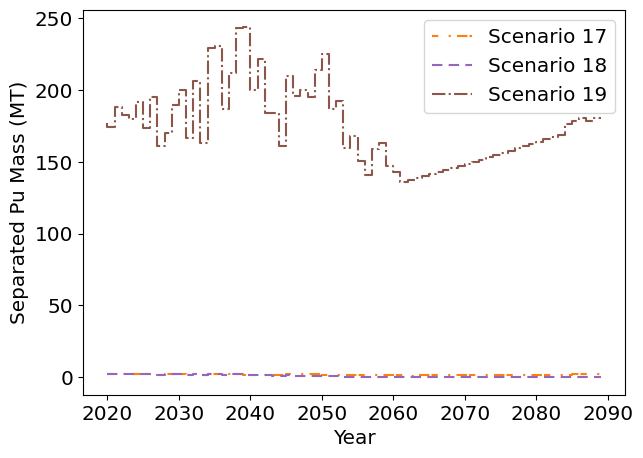

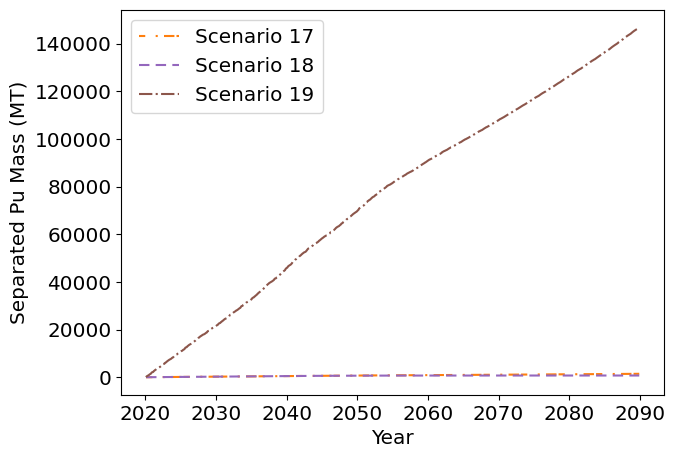

In [41]:
for key in sep_pu_1percent:
    counter = 661
    averages = []
    for ii in range(0, 70):
        year_data = sep_pu_1percent[key]['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2020, 2089, 70), averages, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Separated Pu Mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_sep_pu.pdf")
    
    plt.figure(2)
    plt.plot(sep_pu_1percent[key]['Year'][661:], sep_pu_1percent[key]['Quantity'][661:].cumsum()/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Separated Pu Mass (MT)')
    plt.legend()
    plt.savefig("figures/1percent_recycle_sep_pu_cumulative.pdf")

In [42]:
#reporting seaparated Pu masses
for scenario in transactions_senders_1percent:
    print('Average Sep Pu in', scenario, 'after 2020:', sep_pu_1percent[scenario]['Quantity'][721:].mean()/1000)
    print('Maximum  Sep Pu in', scenario, ':', sep_pu_1percent[scenario]['Quantity'][721:].max()/1000)
    print('Cumulative Sep Pu in', scenario, ':', sep_pu_1percent[scenario]['Quantity'][721:].cumsum()[1499]/1000)

Average Sep Pu in s17 after 2020: 1.6805139924809496
Maximum  Sep Pu in s17 : 4.734735042744031
Cumulative Sep Pu in s17 : 1309.1204001426586
Average Sep Pu in s18 after 2020: 0.7524648728301933
Maximum  Sep Pu in s18 : 4.734735042743983
Cumulative Sep Pu in s18 : 586.170135934727
Average Sep Pu in s19 after 2020: 174.5817252997552
Maximum  Sep Pu in s19 : 500.0
Cumulative Sep Pu in s19 : 135999.16400850948
